In [1]:
#|default_exp augment

# Augmentation
This notebook covers image augmentation techniques applied to Fashion MNIST.

In [2]:
#|export
import torch, random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, optim
from torch.utils.data import DataLoader, default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
bs = 1024
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [6]:
lr, epochs = 6e-2, 5

## Going wider

In [7]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [8]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.825,0.000,0,train
0.878,0.000,0,eval
0.898,0.000,1,train
0.888,0.000,1,eval
0.922,0.000,2,train
0.911,0.000,2,eval
0.943,0.000,3,train
0.927,0.000,3,eval
0.965,0.000,4,train
0.932,0.000,4,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

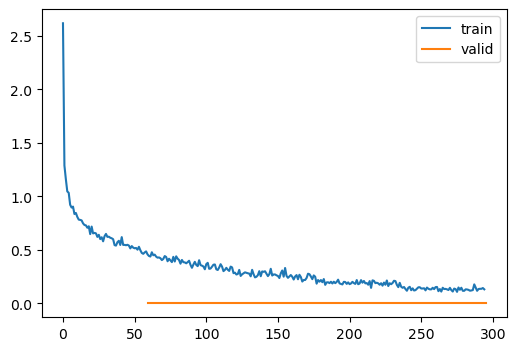

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [9]:
learn.fit(epochs)

## Pooling
Pooling works similar to stride = 2, where it downsizes the image and tries to capture important details about the image.

In [10]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [11]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [12]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [13]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.824,0.000,0,train
0.858,0.000,0,eval
0.901,0.000,1,train
0.896,0.000,1,eval
0.924,0.000,2,train
0.908,0.000,2,eval
0.944,0.000,3,train
0.928,0.000,3,eval
0.965,0.000,4,train
0.931,0.000,4,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

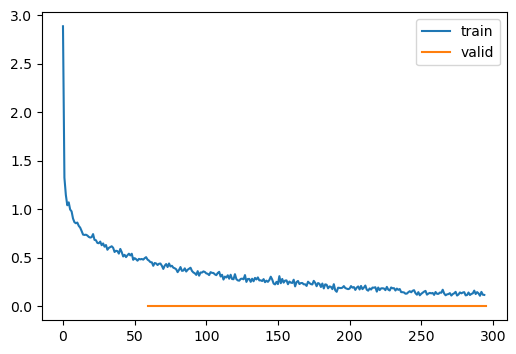

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [14]:
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Data augmentation
Data augmentation refers to creating 'new' samples from the existing dataset. The goal is to show the model more variations of the same image to help the model better generalise.

In [15]:
from torchvision import transforms

In [16]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
# SingleBatchCB to view one batch of data post-augmentation
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [17]:
learn.fit(1)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

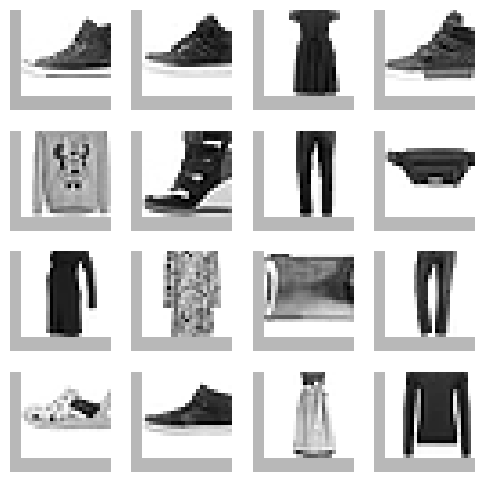

In [18]:
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

We can see from the translation of the images that they have been cropped a bit.

In [19]:
#|export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    #self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

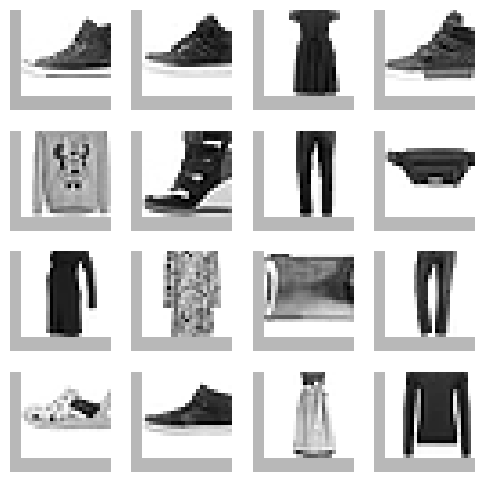

In [20]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [21]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

Now, let's test our performance on 20 epochs, i.e. if there is space for further improvement with more epochs.

accuracy,loss,epoch,train
0.769,0.000,0,train
0.841,0.000,0,eval
0.861,0.000,1,train
0.853,0.000,1,eval
0.879,0.000,2,train
0.863,0.000,2,eval
0.884,0.000,3,train
0.879,0.000,3,eval
0.893,0.000,4,train
0.880,0.000,4,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

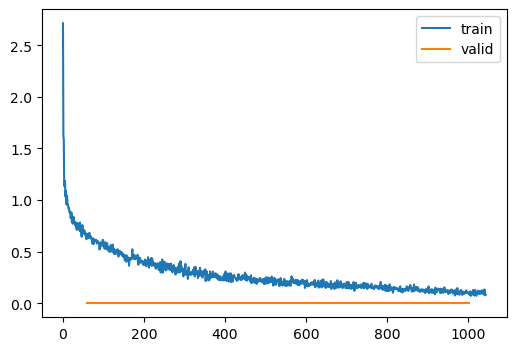

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [22]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

We see that we've managed to get an evaluation score of 0.942 with data augmentation and more epochs.

## Test time augmentation (TTA)
TTA works by feeding different transformed images to the trained model and averaging the predictions in order to get a more confident prediction.

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

In [ ]:
ap1, at = learn.capture_preds()

In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

We see that TTA gives us a marginally better result.

## Random erase
As the name suggests, random erase works by randomly erasing part of the image. The goal is to teach the model to better generalise.

In [ ]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
xm, xs = xbt.mean(), xbt.std()

In [ ]:
xbt.mean(), xbt.max()

In [ ]:
pct = 0.2

In [ ]:
xbt.shape[-2]

In [ ]:
size_x = int(pct*xbt.shape[-2])
size_y = int(pct*xbt.shape[-1])
start_x = int(random.random()* (1-pct) * xbt.shape[-2])
start_y = int(random.random()* (1-pct) * xbt.shape[-1])

In [ ]:
size_x, size_y, start_x, start_y

In [ ]:
init.normal_(xbt[:,:, start_x:start_x+size_x, start_y:start_y+size_y], mean=xm, std=xs)

In [ ]:
show_images(xbt, imsize=1.5)

We can see that the top left of the image has been randomly erased.

In [ ]:
#|export
def _rand_erase1(x, pct, xm, sx, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [ ]:
#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

In [ ]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
epochs = 20
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Random copy
We randomly copy one small part of the image and place that copied section to another part of the image.

In [ ]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

In [ ]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

In [ ]:
show_images(xbt, imsize=1.5)

In [ ]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]


In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
    return x

In [ ]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

We combine our predictions from our augmented model with non-augmented model and see if we can get a higher performing score.

In [ ]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [ ]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)

In [ ]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

In [ ]:
ap = torch.stack([cp1.all_preds, cp2.all_preds]).mean(0).argmax(1)

In [ ]:
round((ap==cp1.all_targs).float().mean().item(), 3)

## Dropout
